Here's an attempt to create a recommendation engine with this dataset. Our Naive assumption is that a person's taste in film does not evolve with time.

In [25]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
%pylab inline
from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

Populating the interactive namespace from numpy and matplotlib


In [3]:
df = pd.read_csv('movie_metadata.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
color                        5024 non-null object
director_name                4939 non-null object
num_critic_for_reviews       4993 non-null float64
duration                     5028 non-null float64
director_facebook_likes      4939 non-null float64
actor_3_facebook_likes       5020 non-null float64
actor_2_name                 5030 non-null object
actor_1_facebook_likes       5036 non-null float64
gross                        4159 non-null float64
genres                       5043 non-null object
actor_1_name                 5036 non-null object
movie_title                  5043 non-null object
num_voted_users              5043 non-null int64
cast_total_facebook_likes    5043 non-null int64
actor_3_name                 5020 non-null object
facenumber_in_poster         5030 non-null float64
plot_keywords                4890 non-null object
movie_imdb_link              5043 non-

Since cleaning the data is not the focus of this notebook, I'll just dump it all in one cell. That way we can skip over to the nice parts.

In [4]:
first_actors = set(df.actor_1_name.unique())
second_actors = set(df.actor_2_name.unique())
third_actors = set(df.actor_3_name.unique())
print('Those only in first name', len(first_actors - second_actors - third_actors))
print('Those only in second name', len(second_actors - first_actors - third_actors))
print('Those only in third name', len(third_actors - first_actors - second_actors))
# ----is it color or not
df.color = df.color.map({'Color': 1, ' Black and White':0})
# ---- Genres as on-off flags instead of strings
unique_genre_labels = set()
for genre_flags in df.genres.str.split('|').values:
    unique_genre_labels = unique_genre_labels.union(set(genre_flags))
for label in unique_genre_labels:
    df['Genre='+label] = df.genres.str.contains(label).astype(int)
df = df.drop('genres', axis=1)

# Titles are supposed to be unique right?
if len(df.drop_duplicates(subset=['movie_title',
                                  'title_year',
                                  'movie_imdb_link'])) < len(df):
    print('Duplicate Titles Exist')
    # Let's see these duplicates.
    duplicates = df[df.movie_title.map(df.movie_title.value_counts() > 1)]
    duplicates.sort('movie_title')[['movie_title', 'title_year']]
    # Looks like there are duplicates after all. Let's drop those.
    df = df.drop_duplicates(subset=['movie_title', 'title_year', 'movie_imdb_link'])
    # df.info()
counts = df.language.value_counts()
df.language = df.language.map(counts)
#df.language
count = df.country.value_counts()
df.country = df.country.map(count)
#df.country
counts = df.content_rating.value_counts()
df.content_rating = df.content_rating.map(counts)
#df.content_rating
#df.plot_keywords.head()
unique_words = set()
for wordlist in df.plot_keywords.str.split('|').values:
    if wordlist is not np.nan:
        unique_words = unique_words.union(set(wordlist))
plot_wordbag = list(unique_words)
for word in plot_wordbag:
    df['plot_has_' + word.replace(' ', '-')] = df.plot_keywords.str.contains(word).astype(float)
df = df.drop('plot_keywords', axis=1)
# Is anything left to be done other than imputing?
print(df.select_dtypes(include=['O']).columns)
# We replace director name with counts of movies they've done
df.director_name = df.director_name.map(df.director_name.value_counts())
# We replace actor names with the number of movies they appear in.
counts = pd.concat([df.actor_1_name, df.actor_2_name, df.actor_3_name]).value_counts()
#counts.head()
df.actor_1_name = df.actor_1_name.map(counts)
df.actor_2_name = df.actor_2_name.map(counts)
df.actor_3_name = df.actor_3_name.map(counts)
# I have no clue what to do with the title. I'll keep it for now in order to search by name
df = df.drop(['movie_imdb_link'], axis=1)
# Let's check if anything is left as object
df.select_dtypes(include=['O']).columns

('Those only in first name', 865)
('Those only in second name', 1469)
('Those only in third name', 2126)
Duplicate Titles Exist
Index([u'director_name', u'actor_2_name', u'actor_1_name', u'movie_title',
       u'actor_3_name', u'movie_imdb_link'],
      dtype='object')


Index([u'movie_title'], dtype='object')

In [5]:
df.shape

(4919, 8136)

# Now the data is clean enough. Recommend already!
It's filled with holes though. Pun intended. :D

I wanted to try out some fancy imputation (there's a package by that name too) so here goes.

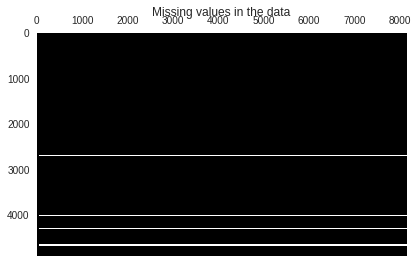

In [6]:
# hold your horses, we still need to fill those missing values.
new_style = {'grid': False}
matplotlib.rc('axes', **new_style)
plt.matshow(~df.isnull())
plt.title('Missing values in the data')

((4767, 8136), (4919, 8136))


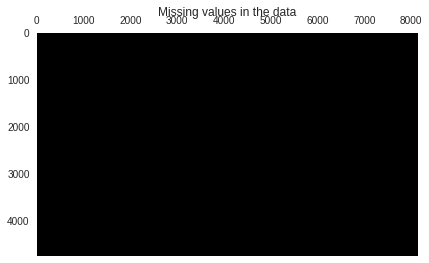

In [7]:
# Let's get those rows which are mostly incomplete. I suspect this was because of our
# new features being created from old ones which were null.
nullcount = df.isnull().sum(axis=1)
# Let's just keep those who have less than a hundred missing values
ndf = df.dropna(thresh=100)
print(ndf.shape, df.shape)
# Let's see those nulls again
plt.matshow(~ndf.isnull())
plt.title('Missing values in the data')

In [8]:
# We'll treat fillna as a regression / classification problem here.
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

def reg_class_fill(df, column, classifier):
    """Treat missing values as a classification / regresion problem"""
    ndf = df.dropna(subset=[col for col in df.columns if col != column])
    nullmask = ndf[column].isnull()
    train, test  = ndf[~nullmask], ndf[nullmask]
    train_x, train_y = train.drop(column, axis=1), train[column]
    classifier.fit(train_x, train_y)
    if len(test) > 0:
        test_x, test_y = test.drop(column, axis=1), test[column]
        values = classifier.predict(test_x)
        test_y = values
        new_x, new_y = pd.concat([train_x, test_x]), pd.concat([train_y, test_y])
        newdf = new_x[column] = new_y
        return newdf
    else:
        return ndf

In [9]:
r, c = KNeighborsRegressor, KNeighborsClassifier  # Regress or classify
title_encoder = LabelEncoder()
title_encoder.fit(ndf.movie_title)
ndf.movie_title = title_encoder.transform(ndf.movie_title)

In [10]:
print(ndf[ndf.columns[:25]].isnull().sum())

color                         13
director_name                 93
num_critic_for_reviews        26
duration                       8
director_facebook_likes       93
actor_3_facebook_likes        17
actor_2_name                  10
actor_1_facebook_likes         7
gross                        751
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  17
facenumber_in_poster          11
num_user_for_reviews           7
language                       8
country                        3
content_rating               223
budget                       445
title_year                    93
actor_2_facebook_likes        10
imdb_score                     0
aspect_ratio                 244
movie_facebook_likes           0
dtype: int64


In [11]:
# Since our imputation will impact other imputations, we specify an order
# Typically we should do this independently and then combine the results, but meh for now
impute_order = [('director_name', c), ('title_year', c),
                ('actor_1_name', c), ('actor_2_name', c), ('actor_3_name', c),
                ('gross', r), ('budget', r), ('aspect_ratio', r),
                ('content_rating', r), ('num_critic_for_reviews', r)]
for col, classifier in impute_order:
    ndf = reg_class_fill(ndf, col, classifier())
    print(col, 'Done')

('director_name', 'Done')
('title_year', 'Done')
('actor_1_name', 'Done')
('actor_2_name', 'Done')
('actor_3_name', 'Done')
('gross', 'Done')
('budget', 'Done')
('aspect_ratio', 'Done')
('content_rating', 'Done')
('num_critic_for_reviews', 'Done')


In [12]:
# Again we check for what else needs to be imputed.
ndf[ndf.columns[:25]].isnull().sum()

color                        0
director_name                0
num_critic_for_reviews       0
duration                     0
director_facebook_likes      0
actor_3_facebook_likes       0
actor_2_name                 0
actor_1_facebook_likes       0
gross                        0
actor_1_name                 0
movie_title                  0
num_voted_users              0
cast_total_facebook_likes    0
actor_3_name                 0
facenumber_in_poster         0
num_user_for_reviews         0
language                     0
country                      0
content_rating               0
budget                       0
title_year                   0
actor_2_facebook_likes       0
imdb_score                   0
aspect_ratio                 0
movie_facebook_likes         0
dtype: int64

In [13]:
# Did we get everything?
ndf.isnull().sum().sum()

0

In [14]:
# YAY! We did indeed get everything, though it may not have been very good.
# Now we redo the movie title transformation for our searches.
titles = title_encoder.inverse_transform(ndf.movie_title)
#titles = [i.lower().strip() for i in titles]

# And we are ready to recommend stuff to you love :D
We build a simple KD tree recommender.

In [15]:
# Give us 5 movies that you liked
def get_movies(names):
    movies = []
    for name in names:
        found = [i for i in titles if name.lower() in i.lower()]
        if len(found) > 0:
            movies.append(found[0])
            print(name, ': ', found, 'added', movies[-1], 'to movies')
        else:
            print(name, ': ', found)
    print('-'*10)
    print(movies)
    moviecodes = title_encoder.transform(movies)
    return moviecodes, movies
names = ['fight club', 'gump', # This one is Forrest Gump
                 'usual suspects', 'silence of the lambs']
moviecodes, movies = get_movies(names)

('fight club', ': ', ['Fight Club\xc2\xa0'], 'added', 'Fight Club\xc2\xa0', 'to movies')
('gump', ': ', ['Forrest Gump\xc2\xa0'], 'added', 'Forrest Gump\xc2\xa0', 'to movies')
('usual suspects', ': ', ['The Usual Suspects\xc2\xa0'], 'added', 'The Usual Suspects\xc2\xa0', 'to movies')
('silence of the lambs', ': ', ['The Silence of the Lambs\xc2\xa0'], 'added', 'The Silence of the Lambs\xc2\xa0', 'to movies')
----------
['Fight Club\xc2\xa0', 'Forrest Gump\xc2\xa0', 'The Usual Suspects\xc2\xa0', 'The Silence of the Lambs\xc2\xa0']


In [16]:
data = ndf.drop('movie_title', axis=1)
data = MinMaxScaler().fit_transform(data)

In [17]:
# We assume KNN's assumptions as valid and proceede to compute a distance_matrix
from sklearn.neighbors import KDTree
from collections import Counter

In [18]:
movies

['Fight Club\xc2\xa0',
 'Forrest Gump\xc2\xa0',
 'The Usual Suspects\xc2\xa0',
 'The Silence of the Lambs\xc2\xa0']

In [19]:
titles

array(['Avatar\xc2\xa0',
       "Pirates of the Caribbean: At World's End\xc2\xa0",
       'Spectre\xc2\xa0', ..., 'Primer\xc2\xa0', 'El Mariachi\xc2\xa0',
       'My Date with Drew\xc2\xa0'], dtype=object)

In [20]:
tree = KDTree(data, leaf_size=2)

In [21]:
def recommend(movies, tree, titles, data):
    """
    It is assumed that the movies are in order of decreasing like-able-ness
    Recommend movies on the basis of the KDTree generated.
    Return them in order of increasing distance form knowns.
    """
    titles = list(titles)
    length, recommendations = len(movies) + 1,[]
    
    for i, movie in enumerate(movies):
        weight = length - i
        dist, index = tree.query([data[titles.index(movie)]], k=3)
        for d, m in zip(dist[0], index[0]):
            recommendations.append((d*weight, titles[m]))
    recommendations.sort()
    # Stuff is reorganized by frequency.
    rec = [i[1].strip() for i in recommendations if i[1] not in movies]
    rec = [i[1] for i in sorted([(v, k) for k, v in Counter(rec).items()],
                                reverse=True)]
    return rec

In [22]:

rec = recommend(movies, tree, titles, data)

print('Rank | Movie')
print('-----|------')
fmt = '{}.   | {}'
for index, movie in enumerate(rec[:9]):
    print(fmt.format(index + 1, movie))

Rank | Movie
-----|------
1.   | Black or White 
2.   | Untraceable 
3.   | The Young Messiah 
4.   | The Second Best Exotic Marigold Hotel 
5.   | Suspect Zero 
6.   | Blood Ties 
7.   | 15 Minutes 


# Tadaa!
It's not very neat and awesome! But I did like Untraceable to be honest. 
Some movies are recommended twice! Probably because they are quiet close to multiple choices.

## What else can be done?

- Feature generation: I've done a nasty job of generating features. That could be cleaned up.
- Imputation: A better way of imputing is welcome. Perhaps even need I say.
- Some other recommendation method: So far I've only been able to discover KDTrees. If someone could write another one, awesome!

*Upvote* to show your appreciation. :D

# The final product

1. Get movie titles
2. Recommend

In [23]:
names = ['hesher', 'leaving las vegas'] # dedicated to A.S.
moviecodes, movies = get_movies(names)
rec = recommend(movies, tree, titles, data)
print('-'*50)
print('Recommending on the basis of the above movies')
print('-'*50)
print()
print('+-----|------')
print('|Rank | Movie')
print('+-----|------')
fmt = '|{}.   | {}'
for index, movie in enumerate(rec[:9]):
    print(fmt.format(index + 1, movie))
print('+-----|------')

('hesher', ': ', ['Hesher\xc2\xa0'], 'added', 'Hesher\xc2\xa0', 'to movies')
('leaving las vegas', ': ', ['Leaving Las Vegas\xc2\xa0'], 'added', 'Leaving Las Vegas\xc2\xa0', 'to movies')
----------
['Hesher\xc2\xa0', 'Leaving Las Vegas\xc2\xa0']
--------------------------------------------------
Recommending on the basis of the above movies
--------------------------------------------------
()
+-----|------
|Rank | Movie
+-----|------
|1.   | The Young Messiah 
|2.   | Message in a Bottle 
|3.   | Little Children 
|4.   | Black or White 
+-----|------
